Red neuronal que clasifica imagenes en dos clases: gato o perro.

# Imports

In [47]:

import tensorflow as tf
from tensorflow import keras
import kerastuner as kt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
from keras.utils import image_dataset_from_directory

In [50]:
from tensorflow.data.experimental import cardinality

In [51]:
from tensorflow.keras import models
from tensorflow.keras import layers


In [52]:
from keras.callbacks import TensorBoard
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [53]:
from keras.preprocessing.image import ImageDataGenerator

In [54]:
from kerastuner.tuners import RandomSearch

# Funciones

In [77]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, data_aug_fun):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (data_aug_fun(x), y), 
              num_parallel_calls=AUTOTUNE)

  # if shuffle:
  #   ds = ds.shuffle(1000)

  # Batch all datasets.
  # ds = ds.batch(batch_size)

    
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

# Configuración

Diferentes confiugraciones respectivas a los datos y las redes

In [56]:
loss_fun = 'binary_crossentropy'
out_layer_neurons = 1
out_layer_activ = 'sigmoid'
ds_label_mode = 'int'

# loss_fun = 'categorical_crossentropy'
# out_layer_neurons = 2
# out_layer_activ = 'softmax'
# ds_label_mode = 'categorical'

# Métodos para visualización

In [57]:
def plot_examples(dataset):
    plt.figure(figsize=(10, 10))
    # Take devuelve un batch aleatorio de 32 objetos. Siendo estos objetos un par de matriz de pixeles y label
    print(dataset)
    for images, labels in dataset.take(2):
    
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # if i == 0:
        #     print(images[i].numpy().astype("uint8"))
        print(images[i])
        plt.imshow(images[i].numpy().astype("uint8"))
        # Si se ha hecho onehot encoding con las labels
        if labels.dtype == 'float32':
            label = tf.argmax(labels[i].numpy(), axis=0)
            plt.title(class_names[label.numpy()])
        # Si las labels son un numero
        elif labels.dtype == 'int32':
            plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.plot()

In [58]:
def show_curves(train, type):
    pd.DataFrame(train.history)[[type, f'val_{type}']].plot(figsize=(10, 6))
    plt.grid(True)
    plt.xlabel("epochs")
    plt.ylabel(type)
    plt.show()

In [59]:
def show_image(ds, batch, img_num):
    # Solo devuelve el primer batch siempre, arreglar
    image = ds.take(1)
    img = next(iter(image))[0]
    plt.imshow(img[img_num].numpy().astype("uint8"))

# Carga de datos

## Datos entrenamiento

Aquí hay un ejemplo de técnicas a utilizar: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/

In [63]:
image_path = 'datasets\cats_and_dogs'

In [64]:
batch_size = 32
img_height = 128
img_width = 128

Sobre tamaños de imagen comunes en RNC:

- **32x32 o 64x64**: Para tareas simples o datasets como CIFAR-10/100.
- **128x128 o 224x224**: Tamaños comunes que ofrecen un buen balance entre detalle y carga computacional.
- **299x299 o más**: Para tareas que requieren mucha precisión y donde el hardware lo permite, como modelos Inception o análisis de imágenes de alta resolución.

In [65]:
train_ds = image_dataset_from_directory(
  image_path+"/training_set",
  # validation_split=1,
  # subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=ds_label_mode,
)

Found 8000 files belonging to 2 classes.


In [66]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

- image_size cambia el tamaño de todas las imágenes directamente
- batch size agrupa los datos en batches
- label mode cambia el formato de las labels. Al ponerlo en categorical, se hace one hot encoding automáticamente.

In [67]:
print(cardinality(train_ds).numpy())

250


In [68]:
class_names = train_ds.class_names

Al cargar datos utilizando **image_dataset_from_directory**, se aplican transformaciones directamente. Por ejemplo, estará randomizado, por lo que por ejemplo en cada iteración que mostremos las imágenes, estas serán distintas siempre. Además. se aplicará el tamaño de la imagen que querramos directamente. 

## Visualizar datos de entrenamiento

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
tf.Tensor(
[[[167.       182.       187.      ]
  [167.89062  182.89062  187.89062 ]
  [169.48438  184.48438  189.48438 ]
  ...
  [162.65625  112.65625   85.65625 ]
  [161.59375  111.59375   84.59375 ]
  [161.       111.        84.      ]]

 [[167.08594  182.08594  187.08594 ]
  [168.00208  183.00208  188.00208 ]
  [169.64148  184.64148  189.64148 ]
  ...
  [161.625    112.65625   86.34375 ]
  [160.5625   111.59375   85.28125 ]
  [159.96875  111.        84.6875  ]]

 [[167.47656  182.47656  187.47656 ]
  [168.50867  183.50867  188.50867 ]
  [170.35559  185.35559  190.35559 ]
  ...
  [156.9375   112.65625   89.46875 ]
  [155.875    111.59375   88.40625 ]
  [155.28125  111.        87.8125  ]]

 ...

 [[144.52344  138.       110.953125]
  [145.71094  139.1875   112.140625]
  [147.83594  141.3125   114.265625]
  ...
  [164.25781  162.25781  

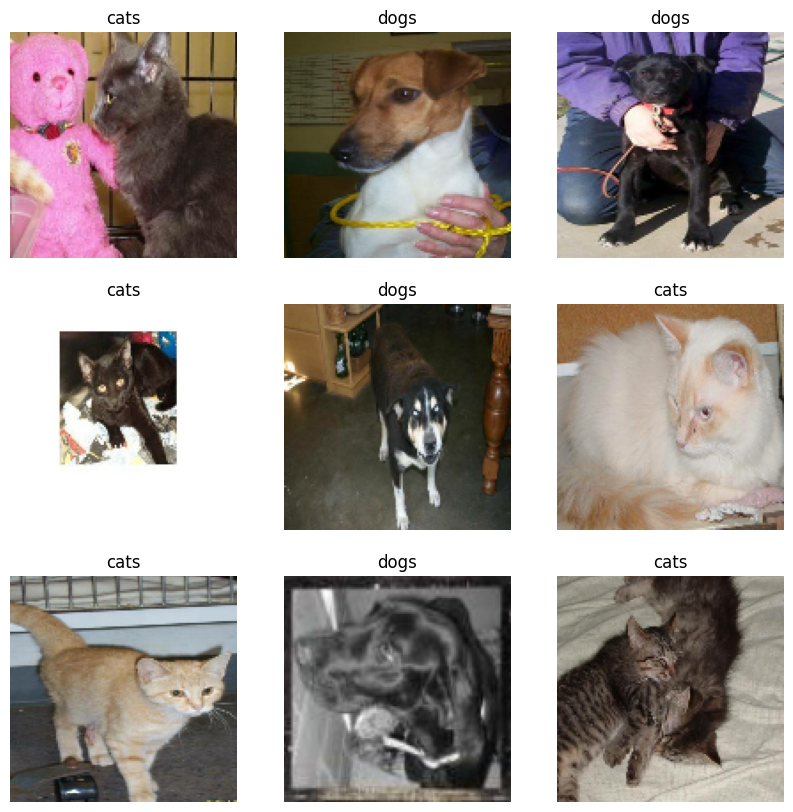

In [69]:
plot_examples(train_ds)

## Cargar conjunto validación y test

Cargamos en un dataset de tensorflow las imagenes de test.

In [70]:
val_ds = image_dataset_from_directory(
  image_path+"/test_set",
  validation_split=0.5,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=ds_label_mode
)

Found 2000 files belonging to 2 classes.
Using 1000 files for training.


De la siguiente forma las dividiremos en set de validation y test.

In [71]:
test_ds = image_dataset_from_directory(
  image_path+"/test_set",
  validation_split=0.5,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode=ds_label_mode
)

Found 2000 files belonging to 2 classes.
Using 1000 files for validation.


In [72]:
val_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
tf.Tensor(
[[[174.03516  151.13672   90.37109 ]
  [179.35156  156.45312   95.55469 ]
  [179.69994  154.8015    94.35228 ]
  ...
  [107.68288   87.800064  36.100845]
  [ 98.44531   80.34375   33.30078 ]
  [ 92.94673   75.557175  28.868607]]

 [[153.71484  118.32422   46.628906]
  [164.2557   130.76953   58.726562]
  [164.59375  136.58203   64.87109 ]
  ...
  [128.22577  110.22577   37.530457]
  [127.25391  110.25391   39.558594]
  [123.04297  108.        36.652344]]

 [[143.4414   103.17969   20.441406]
  [148.91231  111.91016   30.220901]
  [152.93718  119.27312   38.191406]
  ...
  [126.25128  104.513     42.25128 ]
  [124.65274  103.953125  39.29512 ]
  [122.44212  103.262436  37.95169 ]]

 ...

 [[172.0664   153.0664    84.06641 ]
  [168.95312  149.95312   81.75391 ]
  [169.42188  150.42188   82.421875]
  ...
  [126.578125  99.578125 

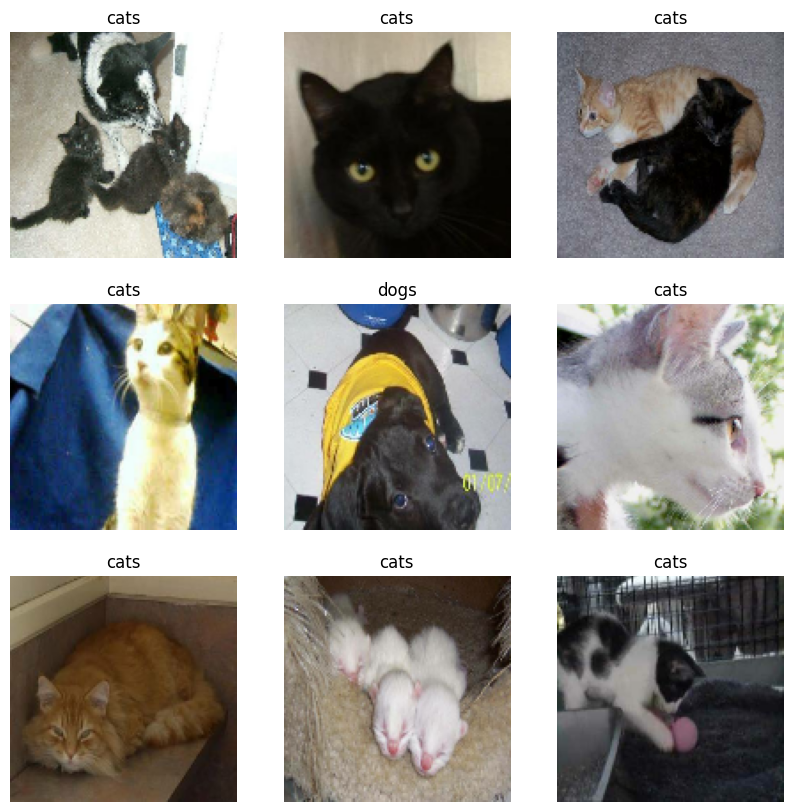

In [73]:
plot_examples(val_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
tf.Tensor(
[[[ 2.903183   2.903183   2.903183 ]
  [ 5.         5.         5.       ]
  [ 2.9333038  2.9333038  2.9333038]
  ...
  [15.878906  19.878906  29.668549 ]
  [18.527344  22.527344  33.006683 ]
  [17.449219  21.449219  33.44922  ]]

 [[ 4.1757812  4.1757812  4.1757812]
  [ 2.6523438  2.6523438  2.6523438]
  [ 4.1210938  4.1210938  4.1210938]
  ...
  [15.878906  19.878906  30.636719 ]
  [18.527344  22.179688  35.222656 ]
  [19.652344  23.652344  35.652344 ]]

 [[ 4.7539062  4.7539062  4.7539062]
  [ 4.7539062  4.7539062  4.7539062]
  [ 4.7539062  4.7539062  4.7539062]
  ...
  [16.9048    20.9048    31.662613 ]
  [19.054688  22.300781  36.5625   ]
  [18.953415  22.953415  34.953415 ]]

 ...

 [[54.36328   48.101562  39.85547  ]
  [57.254333  48.513885  41.38411  ]
  [58.009705  46.827118  40.827118 ]
  ...
  [ 8.301788  12.422882  

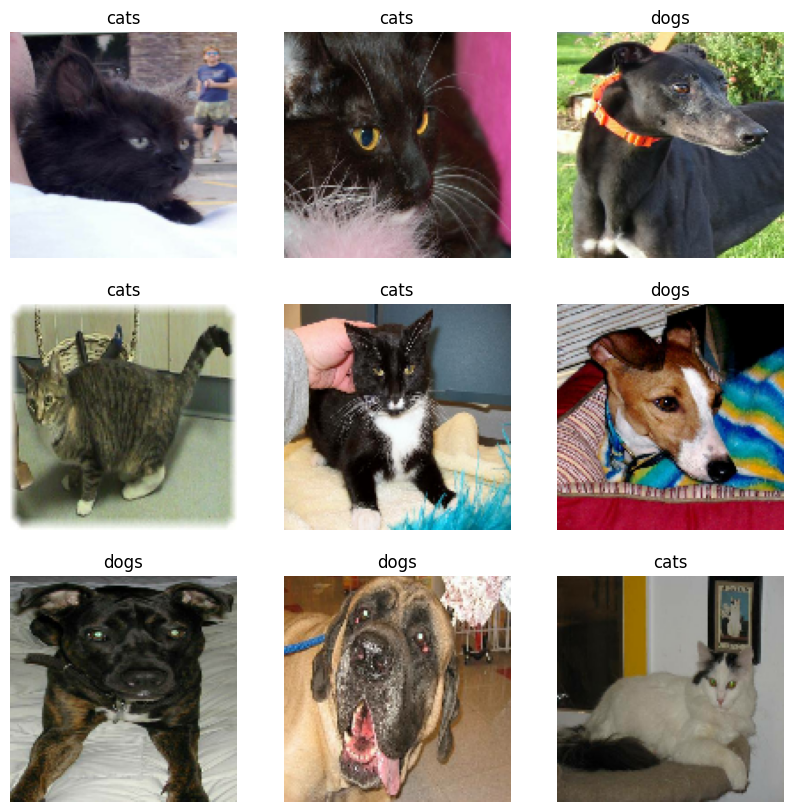

In [74]:
plot_examples(test_ds)


In [75]:
print(cardinality(val_ds).numpy())
print(cardinality(test_ds).numpy())

32
32


# Preparación de los datos

Lo primero que se debe hacer es configurar el dataset de manera que en el entrenamiento se ejecute de la manera más óptima posible. Para esto primero utilizaremos el concepto de **prefetch**. Este permite que mientras se está entrenando, se vaya preprocesando el siguiente paso. Esto es posible mediante el uso de hilos. 

También tenemos que realizar **cache**, el cual almacenará en una especie de caché el dataset. Este caché puede realizarse tanto en memoria como en local.

(Para más info: https://www.tensorflow.org/guide/data_performance)


In [78]:
# Si el rescaling se hace en el modelo, tensorflowjs da fallo
rescale = keras.Sequential([
    layers.Rescaling(1./255)
])

train_ds = prepare(train_ds, rescale)
val_ds = prepare(val_ds, rescale)
test_ds = prepare(test_ds, rescale)

In [79]:


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# Entrenamiento de la red neuronal

En primer lugar hay que entender que al ser este dataset no muy grande, las métricas para una misma red neuronal pueden variar de ejecución a ejecución. Lo que hay que intentar entonces es reducir el valor de accuracy del dataset de entrenamiento para reducir el overfitting, ya que este si que no suele variar mucho

## Primera red neuronal

In [80]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(out_layer_neurons, activation=out_layer_activ)
])

In [81]:
model.compile(
  optimizer='adam',
  loss=loss_fun,
  metrics=['accuracy', 'Precision'])

Se utiliza **BinaryCrossentropy** ya que hemos formateado las labels del dataset con números 0 o 1.

In [82]:
tensorboardRC1 = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainRC1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[tensorboardRC1]
)

Epoch 1/10
250/250 [==============================] - 31s 110ms/step - loss: 0.6614 - accuracy: 0.5883 - precision: 0.5840 - val_loss: 0.5952 - val_accuracy: 0.6700 - val_precision: 0.6199
Epoch 2/10
250/250 [==============================] - 7s 29ms/step - loss: 0.5784 - accuracy: 0.6873 - precision: 0.6953 - val_loss: 0.5501 - val_accuracy: 0.6990 - val_precision: 0.6510
Epoch 3/10
250/250 [==============================] - 7s 29ms/step - loss: 0.5166 - accuracy: 0.7440 - precision: 0.7490 - val_loss: 0.5286 - val_accuracy: 0.7400 - val_precision: 0.7349
Epoch 4/10
250/250 [==============================] - 7s 29ms/step - loss: 0.4520 - accuracy: 0.7861 - precision: 0.7916 - val_loss: 0.5354 - val_accuracy: 0.7250 - val_precision: 0.6904
Epoch 5/10
250/250 [==============================] - 7s 29ms/step - loss: 0.4043 - accuracy: 0.8125 - precision: 0.8144 - val_loss: 0.5142 - val_accuracy: 0.7450 - val_precision: 0.7169
Epoch 6/10
250/250 [==============================] - 7s 29ms/s

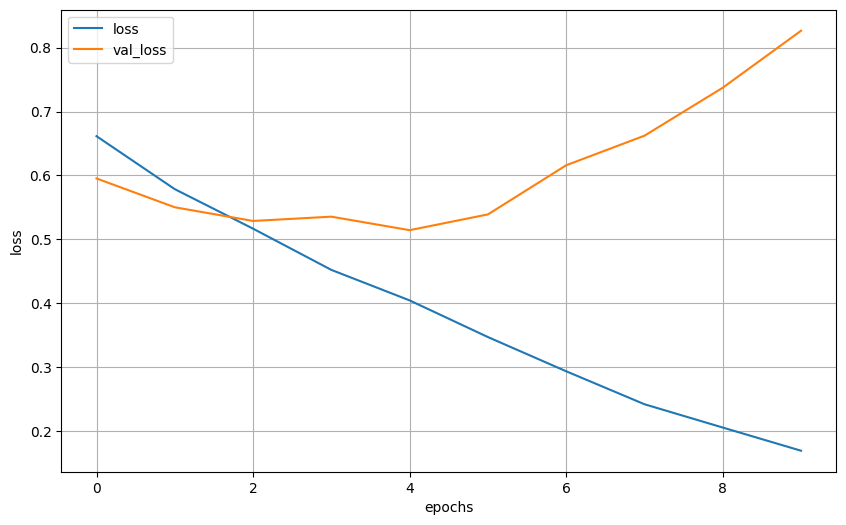

In [83]:
show_curves(trainRC1, 'loss')

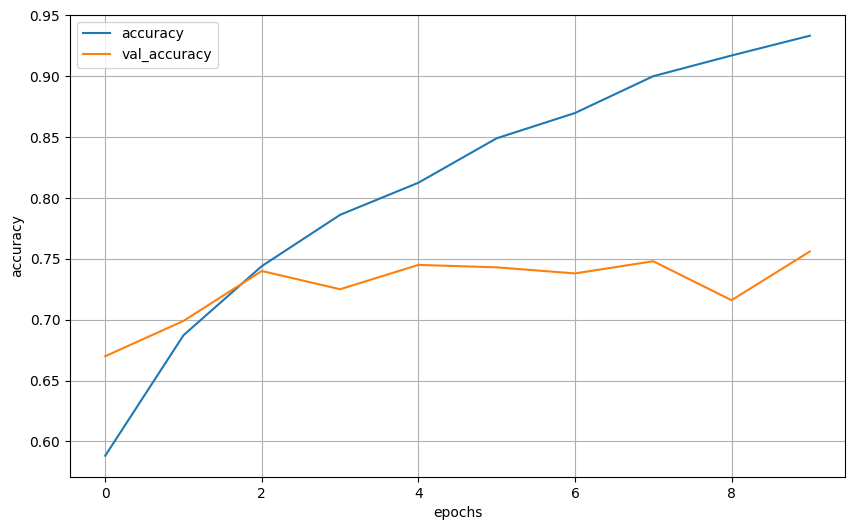

In [84]:
show_curves(trainRC1, 'accuracy')

Como se puede ver, se produce bastante **overfitting**. Vamos a intentar mejorar los resultados de diferentes formas

## Segunda red neuronal

In [400]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(out_layer_neurons, activation=out_layer_activ)
])

In [401]:
model.compile(
  optimizer='adam',
  # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss=loss_fun,
  metrics=['accuracy', 'Precision'])

In [402]:
tensorboardRC1 = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainRC1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[tensorboardRC1]
)

Epoch 1/10
250/250 [==============================] - 9s 34ms/step - loss: 0.6578 - accuracy: 0.6201 - precision: 0.6090 - val_loss: 0.5869 - val_accuracy: 0.7040 - val_precision: 0.7162
Epoch 2/10
250/250 [==============================] - 8s 33ms/step - loss: 0.5578 - accuracy: 0.7131 - precision: 0.7157 - val_loss: 0.5510 - val_accuracy: 0.7240 - val_precision: 0.7234
Epoch 3/10
250/250 [==============================] - 8s 32ms/step - loss: 0.4501 - accuracy: 0.7843 - precision: 0.7933 - val_loss: 0.5893 - val_accuracy: 0.7160 - val_precision: 0.7100
Epoch 4/10
250/250 [==============================] - 8s 33ms/step - loss: 0.3293 - accuracy: 0.8543 - precision: 0.8630 - val_loss: 0.7927 - val_accuracy: 0.7200 - val_precision: 0.6832
Epoch 5/10
250/250 [==============================] - 8s 33ms/step - loss: 0.2209 - accuracy: 0.9098 - precision: 0.9151 - val_loss: 0.8149 - val_accuracy: 0.7160 - val_precision: 0.7100
Epoch 6/10
250/250 [==============================] - 8s 33ms/ste

## Tercera red neuronal

In [487]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
  tf.keras.layers.MaxPooling2D(),
  layers.BatchNormalization(),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.BatchNormalization(),
  
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
    
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.75),
    
    
  tf.keras.layers.Dense(out_layer_neurons, activation=out_layer_activ)
])

In [488]:
model.compile(
  optimizer='adam',
  # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss=loss_fun,
  metrics=['accuracy', 'Precision'],

)

In [489]:
tensorboardRC1 = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainRC1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[tensorboardRC1],
)

Epoch 1/10
250/250 [==============================] - 13s 49ms/step - loss: 0.8549 - accuracy: 0.6259 - precision: 0.6315 - val_loss: 0.9788 - val_accuracy: 0.5070 - val_precision: 0.6667
Epoch 2/10
250/250 [==============================] - 12s 48ms/step - loss: 0.5927 - accuracy: 0.7141 - precision: 0.7216 - val_loss: 0.7264 - val_accuracy: 0.6160 - val_precision: 0.9508
Epoch 3/10
250/250 [==============================] - 12s 48ms/step - loss: 0.4835 - accuracy: 0.7745 - precision: 0.7820 - val_loss: 0.4712 - val_accuracy: 0.7920 - val_precision: 0.7815
Epoch 4/10
250/250 [==============================] - 12s 49ms/step - loss: 0.4192 - accuracy: 0.8068 - precision: 0.8057 - val_loss: 0.4799 - val_accuracy: 0.7890 - val_precision: 0.8361
Epoch 5/10
250/250 [==============================] - 13s 53ms/step - loss: 0.3757 - accuracy: 0.8324 - precision: 0.8336 - val_loss: 0.4809 - val_accuracy: 0.7910 - val_precision: 0.7577
Epoch 6/10
250/250 [==============================] - 12s 50

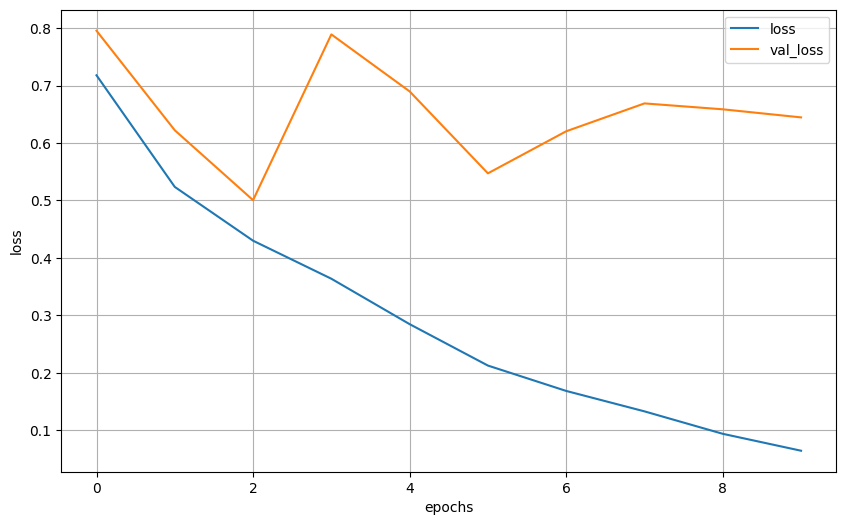

In [482]:
show_curves(trainRC1, 'loss')

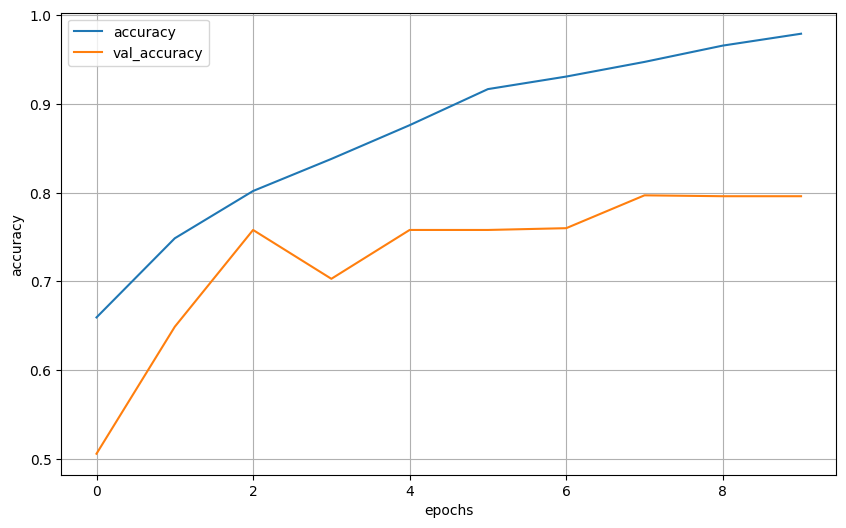

In [483]:
show_curves(trainRC1, 'accuracy')

## Cuarta red neuronal

Añadimos dropout para reducir aun más el overfitting

In [468]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, 3)),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
    
  layers.Dropout(0.5),
  tf.keras.layers.Dense(out_layer_neurons, activation=out_layer_activ)
])

In [469]:
model.compile(
  optimizer='adam',
  # loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  loss=loss_fun,
  metrics=['accuracy', 'Precision'],

)

In [470]:
tensorboardRC1 = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainRC1 = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10,
  callbacks=[tensorboardRC1],
)

Epoch 1/10
250/250 [==============================] - 11s 43ms/step - loss: 0.6829 - accuracy: 0.5540 - precision: 0.5451 - val_loss: 0.6246 - val_accuracy: 0.6600 - val_precision: 0.6878
Epoch 2/10
250/250 [==============================] - 11s 42ms/step - loss: 0.6345 - accuracy: 0.6206 - precision: 0.6514 - val_loss: 0.5911 - val_accuracy: 0.6960 - val_precision: 0.7448
Epoch 3/10
250/250 [==============================] - 11s 42ms/step - loss: 0.5843 - accuracy: 0.6813 - precision: 0.7006 - val_loss: 0.5563 - val_accuracy: 0.7150 - val_precision: 0.6850
Epoch 4/10
250/250 [==============================] - 11s 43ms/step - loss: 0.5364 - accuracy: 0.7225 - precision: 0.7302 - val_loss: 0.5351 - val_accuracy: 0.7290 - val_precision: 0.7061
Epoch 5/10
250/250 [==============================] - 11s 43ms/step - loss: 0.4946 - accuracy: 0.7588 - precision: 0.7603 - val_loss: 0.5043 - val_accuracy: 0.7410 - val_precision: 0.7205
Epoch 6/10
250/250 [==============================] - 10s 42

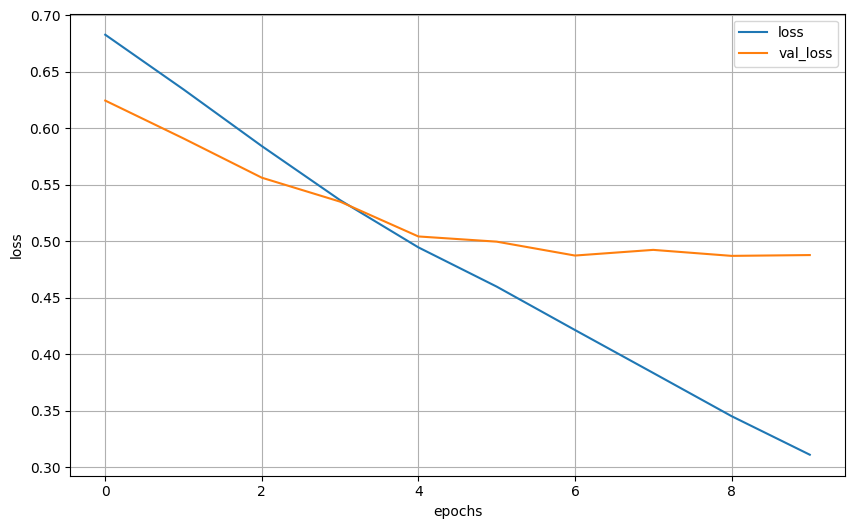

In [471]:
show_curves(trainRC1, 'loss')

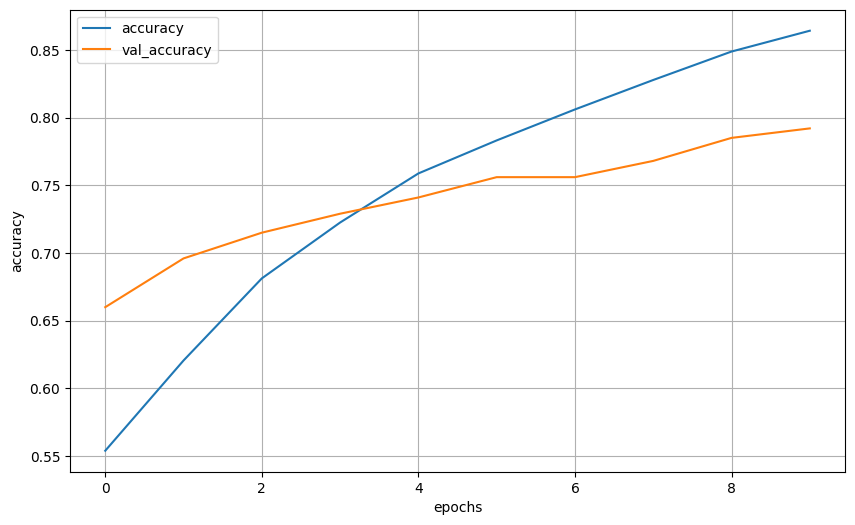

In [472]:
show_curves(trainRC1, 'accuracy')

Podemos ver que seguimos teniendo overfitting pero que mejoran mucho los valores de validación. 

In [282]:
# Guardamos las capas de la red neuronal para utilizarla con los próximos ejemplos
def create_model(color_scale=3):
    # rescaling_layer = tf.keras.layers.Rescaling(1./255, input_shape=(128, 128, color_scale))
    # if color_scale == 1:
    #     rescaling_layer = tf.keras.layers.Rescaling(1./255)
        
    model = keras.Sequential([
      # tf.keras.layers.Rescaling(1./255, input_shape=(128, 128, color_scale)),
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(128, 128, color_scale)),
      tf.keras.layers.MaxPooling2D(),
      layers.Dropout(0.2),
      tf.keras.layers.Conv2D(64, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      layers.Dropout(0.2),
      tf.keras.layers.Conv2D(128, 3, activation='relu'),
      tf.keras.layers.MaxPooling2D(),
      layers.Dropout(0.2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      tf.keras.layers.Dense(out_layer_neurons, activation=out_layer_activ)
    ])
    model.compile(
    optimizer='adam',
    loss=loss_fun,
    metrics=['accuracy', 'Precision'])
    return model

### Comprobación con test ds

In [478]:
model.evaluate(test_ds)

32/32 [==============================] - 3s 61ms/step - loss: 0.6935 - accuracy: 0.8020 - precision: 0.7973


[0.6935123205184937, 0.8020000457763672, 0.7972972989082336]

### Diferencias tercera y cuarta red

Estas dos redes se diferencian en que la tercera  genera más overfitting pero consigue llegar a buenos resultados. La cuarta por otro lado reduce mucho el overfitting, pero llega casi a los mismos resultados. Esto se puede ver después de haber ejecutado varias veces ambas redes.

# Mejora de resultados

## Data augmentation

A partir de la data augmentation podemos variar los datos con diferentes rotaciones, posiciones y ángulos de manera que aprenda más formas en las que pueden aparecer los animales

https://www.tensorflow.org/tutorials/images/data_augmentation

Podemos utilizar estos métodos creando un nuevo dataset o como capas al principio del entrenamiento. La segunda opción tiene la ventaja de que si guardamos el modelo y hacemos una predicción con este, aplicará las mismas operaciones. Esto puede ser interesante para reescalar las imagenes directamente con la capa **Rescaling**. 

Sin embargo, queremos que las operaciones de data augmentation solo se hagan para entrenar con el fin de reducir el overfitting. Por esto, solo aplicaremos las siguientes transformaciones al conjunto de entrenamiento

Hay que tener en cuenta que algunas capas de este tipo no funcionan con Tensorflowjs por lo que no se podrían pasar a una página web o móvil.


In [85]:
# datagen = ImageDataGenerator(
#     height_shift_range=.5,
#     width_shift_range=.5,
#     zoom_range=[.75,1.5],
#     rotation_range=30,
# )

trans_shift = 0.2

data_aug = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation((-trans_shift, trans_shift), (-trans_shift, trans_shift), fill_mode="constant", fill_value=0),
])




In [86]:
aug_ds = prepare(train_ds, data_aug)
aug_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Comprobaciones dataset

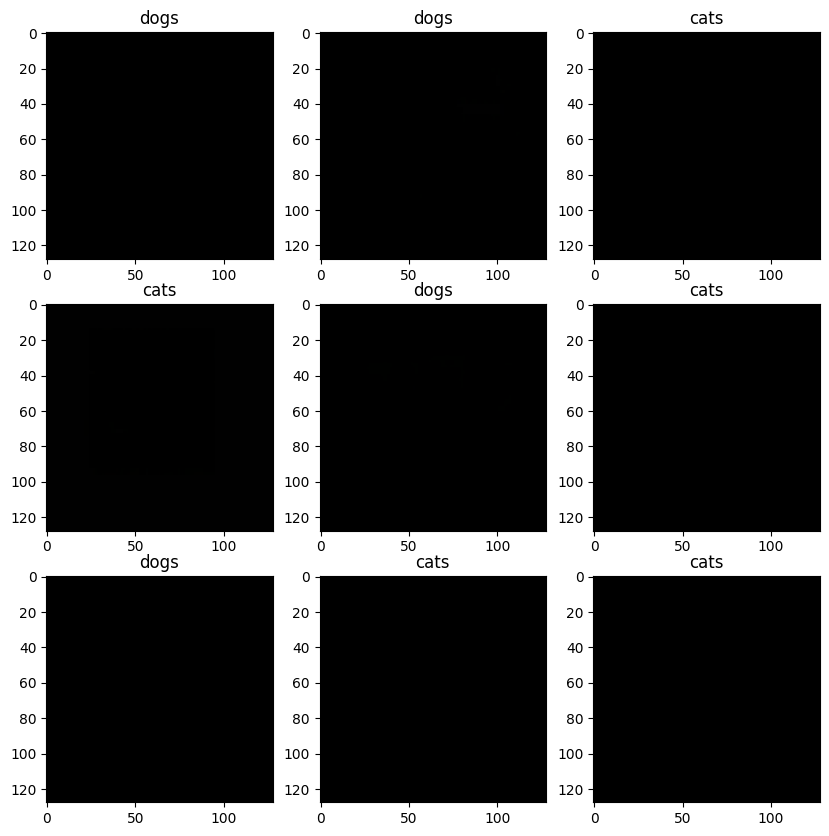

In [285]:
plot_examples(aug_ds)

## Entrenamiento

Ahora entrenaremos la misma red neuronal con estos datos nuevos

In [87]:
modelAUG = create_model()

NameError: name 'create_model' is not defined

In [287]:
tensorboardAUG = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainAUG = modelAUG.fit(
  aug_ds,
  validation_data=val_ds,
  epochs=15,
  callbacks=[tensorboardAUG],
)

Epoch 1/15
250/250 [==============================] - 12s 44ms/step - loss: 0.6969 - accuracy: 0.5339 - precision: 0.5410 - val_loss: 0.6512 - val_accuracy: 0.6620 - val_precision: 0.7932
Epoch 2/15
250/250 [==============================] - 11s 45ms/step - loss: 0.6309 - accuracy: 0.6485 - precision: 0.6561 - val_loss: 0.6045 - val_accuracy: 0.6870 - val_precision: 0.7837
Epoch 3/15
250/250 [==============================] - 11s 44ms/step - loss: 0.5860 - accuracy: 0.6889 - precision: 0.7010 - val_loss: 0.5598 - val_accuracy: 0.7180 - val_precision: 0.7488
Epoch 4/15
250/250 [==============================] - 10s 42ms/step - loss: 0.5534 - accuracy: 0.7168 - precision: 0.7255 - val_loss: 0.5491 - val_accuracy: 0.7200 - val_precision: 0.8323
Epoch 5/15
250/250 [==============================] - 10s 42ms/step - loss: 0.5098 - accuracy: 0.7508 - precision: 0.7598 - val_loss: 0.5006 - val_accuracy: 0.7560 - val_precision: 0.7593
Epoch 6/15
250/250 [==============================] - 10s 42

Dan casi los mismo resultados. Tendremos que probar otro tipo de data augmentation

Encontré un error que no me permitía pasar de la epoch 10 sin que el kernel se reiniciase utilizando DirectMl. Lo que pasaba es que faltaba hacer cache en el dataset. Para entenderlo, profundizaré más en lo que significa hacer cache y prefetch.

Según este [enlace](https://cs230.stanford.edu/blog/datapipeline/#best-practices):

With tf.data, you can do this with a simple call to dataset.prefetch(1) at the end of the pipeline (after batching). This will always prefetch one batch of data and make sure that there is always one ready.

In some cases, it can be useful to prefetch more than one batch. For instance, if the duration of the preprocessing varies a lot, prefetching 10 batches would average out the processing time over 10 batches, instead of sometimes waiting for longer batches.

To give a concrete example, suppose that 10% of the batches take 10s to compute, and 90% take 1s. If the GPU takes 2s to train on one batch, by prefetching multiple batches you make sure that we never wait for these rare longer batch

Y, según la [documentación de Tensorflow](https://www.tensorflow.org/guide/data_performance#caching), el método caché:

"The tf.data.Dataset.cache transformation can cache a dataset, either in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch.

[...]

Here, the data execution time plot shows that when you cache a dataset, the transformations before the cache one (like the file opening and data reading) are executed only during the first epoch. The next epochs will reuse the data cached by thecache transformation.

If the user-defined function passed into the map transformation is expensive, apply the cache transformation after the map transformation as long as the resulting dataset can still fit into memory or local storage. If the user-defined function increases the space required to store the dataset beyond the cache capacity, either apply it after the cache transformation or consider pre-processing your data before your training job to reduce resource usa"

Por lo tanto, como las transformaciones que estabamos realizando para el data augmentation eran bastante complejas, tendremos que ejecutar el método cache despues para mejorar el rendimiento de la GPU y evitar pros

Además, también ayuda eliminar toda la cache de la GPU si sigue ocurriendo el error. Se puede hacer siguiendo las instrucciones de este [video](https://www.youtube.com/watch?v=LkV15i4fack)
e.es."

## Segunda data augmentation

Por otro lado, vemos que los resultados son peores. Ocurre más overfitting. Vamos a intentar cambiar algunos parámetros del data augmentation para lograr mejores resultados:

In [288]:
trans_shift = 0.3

data_aug2 = keras.Sequential([
    # layers.RandomFlip("horizontal_and_vertical"),
    # layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation((-trans_shift, trans_shift), (-trans_shift, trans_shift), fill_mode="constant", fill_value=0),
])

aug_ds2 = prepare(train_ds, data_aug2)
aug_ds2

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [289]:
modelAUG = create_model()

In [290]:
tensorboardAUG2 = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainAUG = modelAUG.fit(
  aug_ds2,
  validation_data=val_ds,
  epochs=15,
  callbacks=[tensorboardAUG2]
)

Epoch 1/15
250/250 [==============================] - 11s 42ms/step - loss: 0.7102 - accuracy: 0.5260 - precision: 0.5277 - val_loss: 0.6888 - val_accuracy: 0.5650 - val_precision: 0.5364
Epoch 2/15
250/250 [==============================] - 10s 41ms/step - loss: 0.6762 - accuracy: 0.5785 - precision: 0.5649 - val_loss: 0.6661 - val_accuracy: 0.5850 - val_precision: 0.5527
Epoch 3/15
250/250 [==============================] - 10s 41ms/step - loss: 0.6541 - accuracy: 0.6171 - precision: 0.6052 - val_loss: 0.6452 - val_accuracy: 0.6180 - val_precision: 0.5838
Epoch 4/15
250/250 [==============================] - 10s 41ms/step - loss: 0.6276 - accuracy: 0.6519 - precision: 0.6400 - val_loss: 0.6036 - val_accuracy: 0.6770 - val_precision: 0.6442
Epoch 5/15
250/250 [==============================] - 10s 41ms/step - loss: 0.5873 - accuracy: 0.6900 - precision: 0.6872 - val_loss: 0.5851 - val_accuracy: 0.6930 - val_precision: 0.6632
Epoch 6/15
250/250 [==============================] - 10s 41

Peores resultados

## Tercera data augmentation

In [291]:
data_aug3 = keras.Sequential([
    layers.RandomFlip("horizontal"),
    # layers.RandomRotation(0.5),
    layers.RandomZoom(0.2),
    # layers.RandomTranslation((-trans_shift, trans_shift), (-trans_shift, trans_shift), fill_mode="constant", fill_value=0),
])

aug_ds3 = prepare(train_ds, data_aug3)
aug_ds3

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [292]:
modelAUG = create_model()

In [293]:
tensorboardAUG2 = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainAUG = modelAUG.fit(
  aug_ds3,
  validation_data=val_ds,
  epochs=15,
  callbacks=[tensorboardAUG2]
)

Epoch 1/15
250/250 [==============================] - 11s 42ms/step - loss: 0.7003 - accuracy: 0.5009 - precision: 0.5012 - val_loss: 0.6883 - val_accuracy: 0.5160 - val_precision: 0.8571
Epoch 2/15
250/250 [==============================] - 10s 42ms/step - loss: 0.6729 - accuracy: 0.5946 - precision: 0.5971 - val_loss: 0.6516 - val_accuracy: 0.6510 - val_precision: 0.7204
Epoch 3/15
250/250 [==============================] - 10s 41ms/step - loss: 0.6185 - accuracy: 0.6598 - precision: 0.6678 - val_loss: 0.5822 - val_accuracy: 0.7090 - val_precision: 0.7221
Epoch 4/15
250/250 [==============================] - 10s 41ms/step - loss: 0.5598 - accuracy: 0.7106 - precision: 0.7157 - val_loss: 0.5251 - val_accuracy: 0.7500 - val_precision: 0.7276
Epoch 5/15
250/250 [==============================] - 11s 42ms/step - loss: 0.5074 - accuracy: 0.7509 - precision: 0.7580 - val_loss: 0.5067 - val_accuracy: 0.7550 - val_precision: 0.7810
Epoch 6/15
250/250 [==============================] - 10s 41

## Conclusión

Podemos concluir que este problema no se beneficia mucho de utilizar data augmentation, ya que dan casi los mismo valores.

## Grayscale

### Entrenamiento

In [294]:

# De esta forma podemos pasar transformaciones de tf.image a capas
grayscale_layer = tf.keras.layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x))

gray = keras.Sequential([
    grayscale_layer
])

gray_ds = prepare(train_ds, gray)
gray_ds


modelGray = create_model(1)

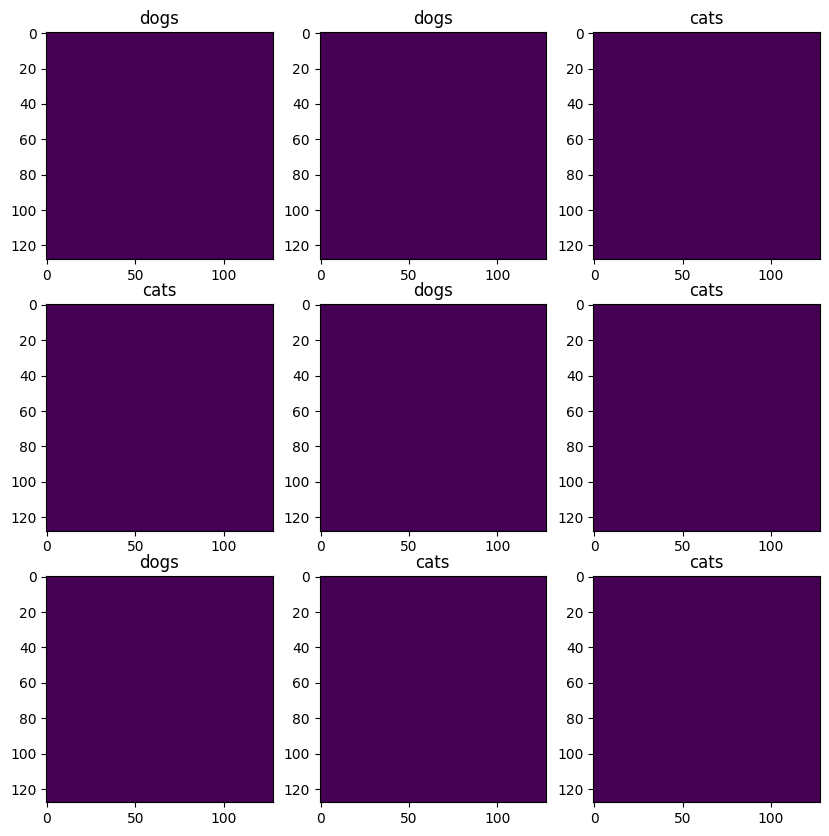

In [295]:
plot_examples(gray_ds)

In [296]:
val_gray_ds = prepare(val_ds, gray)

In [297]:
tensorboardGray = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainGray = modelGray.fit(
  gray_ds,
  validation_data=val_gray_ds,
  epochs=15,
  callbacks=[tensorboardGray]
)

Epoch 1/15
250/250 [==============================] - 11s 41ms/step - loss: 0.6918 - accuracy: 0.5343 - precision: 0.5330 - val_loss: 0.6824 - val_accuracy: 0.5730 - val_precision: 0.5422
Epoch 2/15
250/250 [==============================] - 10s 40ms/step - loss: 0.6659 - accuracy: 0.5943 - precision: 0.5951 - val_loss: 0.6562 - val_accuracy: 0.6420 - val_precision: 0.6405
Epoch 3/15
250/250 [==============================] - 10s 40ms/step - loss: 0.6191 - accuracy: 0.6541 - precision: 0.6666 - val_loss: 0.6086 - val_accuracy: 0.6820 - val_precision: 0.7558
Epoch 4/15
250/250 [==============================] - 10s 40ms/step - loss: 0.5532 - accuracy: 0.7145 - precision: 0.7233 - val_loss: 0.5411 - val_accuracy: 0.7410 - val_precision: 0.7594
Epoch 5/15
250/250 [==============================] - 10s 40ms/step - loss: 0.5059 - accuracy: 0.7604 - precision: 0.7656 - val_loss: 0.5155 - val_accuracy: 0.7560 - val_precision: 0.7063
Epoch 6/15
250/250 [==============================] - 10s 40

Vemos que se mejoran un poco los resultados, pero sigue apareciendo overfitting.

### Data augmentation

In [298]:
data_aug_gray = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2),
    # layers.RandomTranslation((-trans_shift, trans_shift), (-trans_shift, trans_shift), fill_mode="constant", fill_value=0),
])

train_gray_aug_ds = prepare(gray_ds, data_aug_gray)
# val_gray_aug_ds = prepare(val_gray_ds, data_aug_gray)

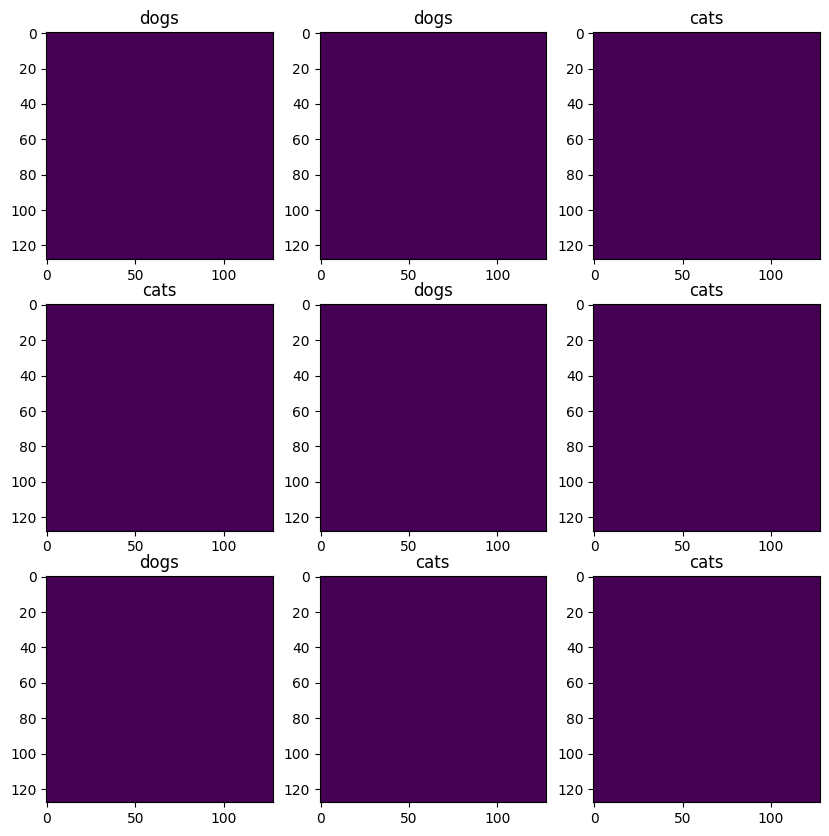

In [299]:
plot_examples(train_gray_aug_ds)

In [300]:
modelGray = create_model(1)

In [301]:
tensorboardGrayFit = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainGray = modelGray.fit(
  train_gray_aug_ds,
  validation_data=val_gray_ds,
  epochs=15,
  callbacks=[tensorboardGrayFit]
)

Epoch 1/15
250/250 [==============================] - 11s 41ms/step - loss: 0.7003 - accuracy: 0.4965 - precision: 0.4977 - val_loss: 0.6931 - val_accuracy: 0.5050 - val_precision: 0.4995
Epoch 2/15
250/250 [==============================] - 10s 40ms/step - loss: 0.6884 - accuracy: 0.5290 - precision: 0.5233 - val_loss: 0.6851 - val_accuracy: 0.5420 - val_precision: 0.5221
Epoch 3/15
250/250 [==============================] - 10s 40ms/step - loss: 0.6835 - accuracy: 0.5539 - precision: 0.5377 - val_loss: 0.6780 - val_accuracy: 0.5670 - val_precision: 0.5384
Epoch 4/15
250/250 [==============================] - 10s 40ms/step - loss: 0.6672 - accuracy: 0.5875 - precision: 0.5724 - val_loss: 0.6357 - val_accuracy: 0.6390 - val_precision: 0.6234
Epoch 5/15
250/250 [==============================] - 10s 40ms/step - loss: 0.6332 - accuracy: 0.6468 - precision: 0.6454 - val_loss: 0.6117 - val_accuracy: 0.6650 - val_precision: 0.6248
Epoch 6/15
250/250 [==============================] - 10s 40

No mejora mucho con este data augmentation. Cambiamos algunos parámetros:

In [302]:
data_aug_gray = keras.Sequential([
    # layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    # layers.RandomTranslation((-trans_shift, trans_shift), (-trans_shift, trans_shift), fill_mode="constant", fill_value=0),
])

train_gray_aug_ds = prepare(gray_ds, data_aug_gray)
# val_gray_aug_ds = prepare(val_gray_ds, data_aug_gray)

modelGray = create_model(1)

In [303]:
tensorboardGrayFit = TensorBoard(log_dir="logs/fit/cats_vs_dogs" + datetime.datetime.now().strftime("%Y--%m--%d-%H,%M,%S"))
trainGray = modelGray.fit(
  train_gray_aug_ds,
  validation_data=val_gray_ds,
  epochs=15,
  callbacks=[tensorboardGrayFit]
)

Epoch 1/15
250/250 [==============================] - 11s 40ms/step - loss: 0.6983 - accuracy: 0.5005 - precision: 0.5006 - val_loss: 0.6927 - val_accuracy: 0.5480 - val_precision: 0.8500
Epoch 2/15
250/250 [==============================] - 10s 39ms/step - loss: 0.6868 - accuracy: 0.5408 - precision: 0.5388 - val_loss: 0.6775 - val_accuracy: 0.5590 - val_precision: 0.8533
Epoch 3/15
250/250 [==============================] - 10s 39ms/step - loss: 0.6532 - accuracy: 0.6173 - precision: 0.6206 - val_loss: 0.5840 - val_accuracy: 0.7100 - val_precision: 0.6925
Epoch 4/15
250/250 [==============================] - 10s 39ms/step - loss: 0.5862 - accuracy: 0.6954 - precision: 0.6985 - val_loss: 0.5701 - val_accuracy: 0.7000 - val_precision: 0.6488
Epoch 5/15
250/250 [==============================] - 10s 39ms/step - loss: 0.5363 - accuracy: 0.7343 - precision: 0.7429 - val_loss: 0.5435 - val_accuracy: 0.7250 - val_precision: 0.6865
Epoch 6/15
250/250 [==============================] - 10s 39

# Exportar modelo

Exportamos el modelo que mejor ha dado resultado

In [304]:
model.save('cats_vs_dogs.h5')

# Keras Tuner

In [25]:
def model_builder(hp):
    # Definición del modelo
    model = keras.Sequential()

    # input layer
    model.add(layers.Conv2D(hp.Int('input_units',
        min_value=32,
        max_value=256,
        step=32), (3, 3), input_shape=(128, 128, 3)))

    dropout_size = hp.Choice('dropout', [0, 0.25, 0.5, 0.75])
    
    # Hidden conv layers 
    for i in range(hp.Int('n_layers', 1, 4)):
        # Añadimos la hidden layer
        model.add(layers.Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3)))
        model.add(layers.MaxPooling2D())
        model.add(layers.Dropout(dropout_size)),

    model.add(layers.Flatten())
    
    # Tuning del número de neuronas de las hidden layer
    hp_units = hp.Int('units', min_value=8, max_value=128, step=8)
    
    # Tuning del número de capas
    hp_layers = hp.Int('layers', min_value=1, max_value=5, step=1)

     # Hidden layers 
    for i in range(hp_layers):
        model.add(layers.Dense(units=hp_units, activation='relu'))
        model.add(layers.Dropout(0.5)),
        
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid'))
   
    
    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(
        optimizer='adam', 
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [36]:
tuner = kt.Hyperband(
    model_builder,
    objective= 'val_accuracy',
    max_epochs=10,
    overwrite=True,
    factor=3,
    directory='hp_dir',
    project_name='cats_vs_dogs_tuner'
)

ValueError: Unrecognized arguments ['max_epochs', 'factor'] for `BaseTuner.__init__()`.

In [26]:
tuner = RandomSearch(
    model_builder,
    objective='val_acc',
    max_trials=5,  # how many model variations to test?
    executions_per_trial=3,  # how many trials per variation? (same model could perform differently)
    directory='hp_dir',
    project_name='cats_vs_dogs_tuner')

Reloading Tuner from hp_dir\cats_vs_dogs_tuner\tuner0.json


In [27]:
tuner.search(
    x=train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size,
)


Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
32                |32                |input_units
0.75              |0.75              |dropout
4                 |4                 |n_layers
96                |96                |conv_0_units
16                |16                |units
5                 |5                 |layers
0.001             |0.001             |learning_rate
32                |32                |conv_1_units
224               |224               |conv_2_units

Epoch 1/10
250/250 [==============================] - 35s 123ms/step - loss: 0.7301 - accuracy: 0.5070 - val_loss: 0.6931 - val_accuracy: 0.5060
Epoch 2/10
250/250 [==============================] - 22s 87ms/step - loss: 0.6954 - accuracy: 0.4969 - val_loss: 0.6930 - val_accuracy: 0.5060
Epoch 3/10
250/250 [==============================] - 22s 87ms/step - loss: 0.6935 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.4950
Epoch 4/10
250/250 [=============================


KeyboardInterrupt





# Tensorboard

In [28]:
%reload_ext tensorboard

In [29]:
%tensorboard --logdir logs/fit --host localhost

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
D:\machine_learning\anaconda\envs\DP-Python39\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
2024-07-01 11:56:54.453076: I tensorflow/c/logging.cc:34] Successfully opened dynamic library D:\machine_learning\anaconda\envs\DP-Python39\lib\site-packages\tensorflow-plugins/directml/directml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.dll
2024-07-01 11:56:54.453747: I tensorflow/c/logging.cc:34] Successfully opened dynamic library dxgi.dll
2024-07-01 11:56:54.456737: I tensorflow/c/logging.cc:34] Successfully opened dynamic library d3d12.dll
2024-07-01 11:56:54.605955: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.
Traceback (most recent call last):
  File "D:\machine_learning\anaconda\envs\DP-Python39\lib\runpy.py", line 197, in _run_module_as_main
    